# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼


In [1]:
!pip install -q chromadb transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [2]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

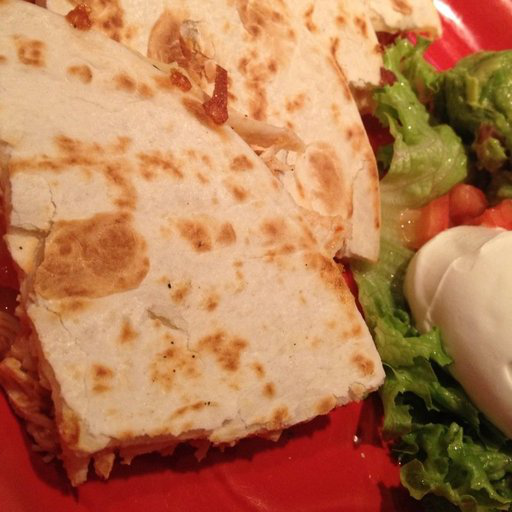

In [3]:
from PIL import Image

img = Image.open("test/Bread/0.jpg")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [4]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [15]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze() #최종 임베딩 벡터

embedding

array([-0.02311962,  0.6290698 , -0.99978113, -0.95486915, -0.1220754 ,
       -0.9384642 ,  0.8637748 ,  0.19353564,  0.97058   ,  0.99590176,
       -0.9996732 , -0.91714656,  0.9640057 , -0.8185951 , -0.9558375 ,
       -0.42468035, -0.99556106, -0.9807443 ,  0.6065122 , -0.99500865,
        0.9554607 , -0.8873271 ,  0.9232541 , -0.96926785, -0.74797714,
        0.9998343 ,  0.7589712 ,  0.9871632 , -0.99997216,  0.8934849 ,
        0.6858151 ,  0.0623833 ,  0.91886693,  0.9965141 , -0.5473017 ,
        0.94086814, -0.7264848 ,  0.8747597 , -0.9615729 ,  0.9884019 ,
       -0.3274302 ,  0.7920269 , -0.99479073, -0.796879  , -0.32671157,
        0.8306039 ,  0.61614823,  0.9859593 ,  0.9093658 , -0.849682  ,
       -0.6554214 , -0.69088465,  0.9802433 , -0.5740967 ,  0.7416012 ,
        0.8988459 , -0.9969229 ,  0.9637099 ,  0.9923487 ,  0.98073846,
       -0.55199397, -0.8963224 , -0.9363188 ,  0.97420645,  0.02392729,
       -0.55839026, -0.6500523 , -0.94184566,  0.97771406, -0.56

In [16]:
embedding.shape #384차원의 벡터

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [23]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods") #관계형 데이터기반의 테이블

## 모든 이미지 벡터화

In [24]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [25]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

    embeddings.append(embedding)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:02<00:00, 47.63it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [ ]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

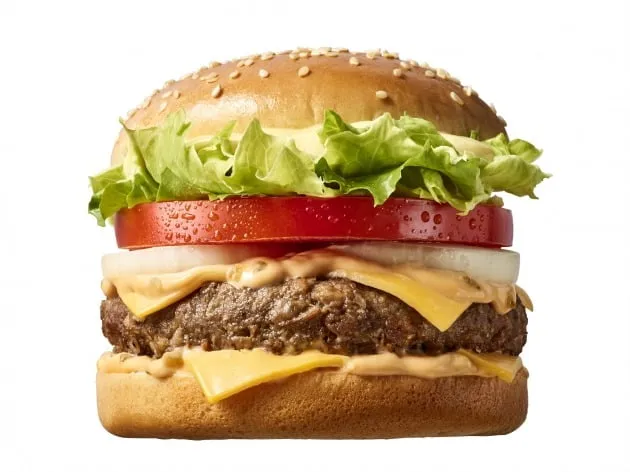

In [11]:
import requests

test_img = Image.open(requests.get("https://i.imgur.com/yNp6qTS.png", stream=True).raw).convert("RGB")

test_img

In [12]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()

test_embedding.shape

(384,)

In [28]:
collection


Collection(name=foods)

In [13]:
query_result = collection.query(
    query_embeddings=[test_embedding],
    n_results=3,
)

query_result

ValueError: ignored

NameError: ignored

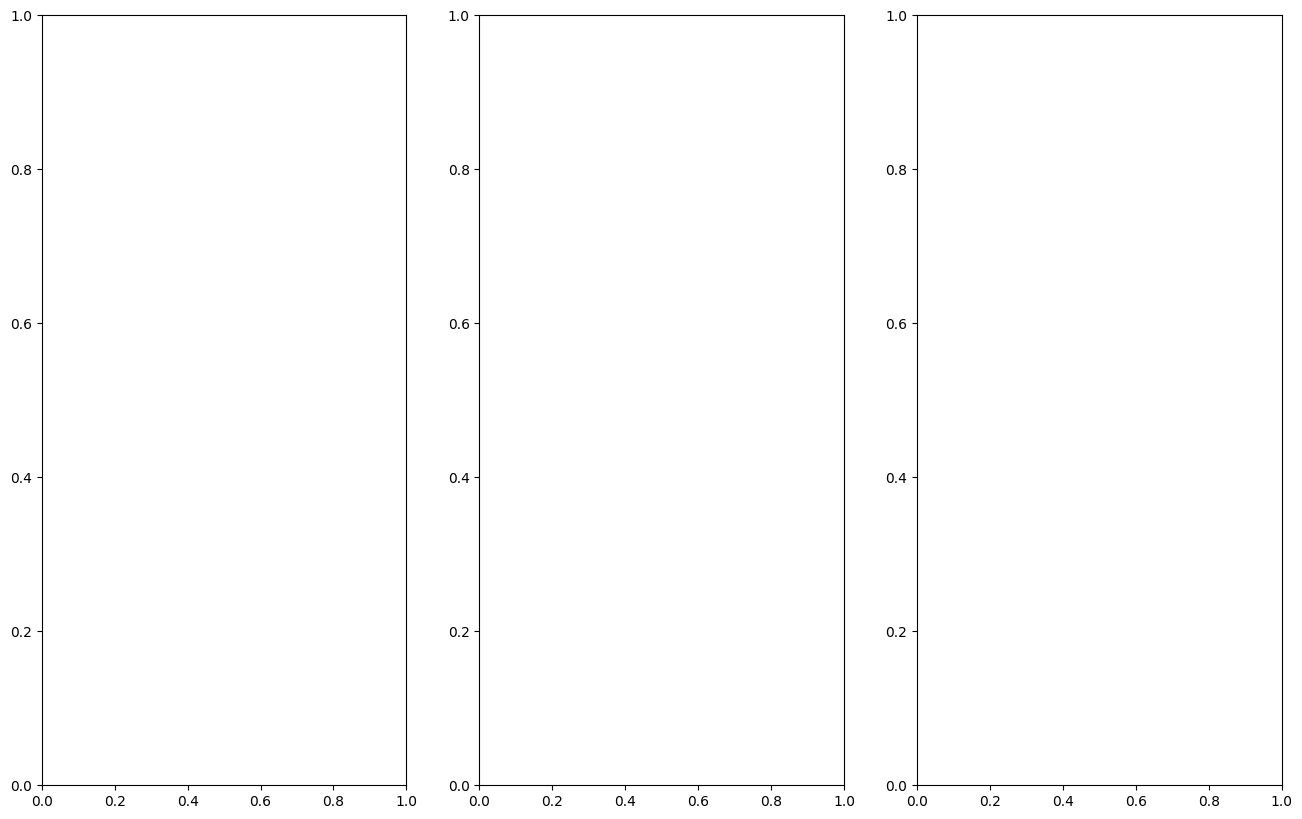

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [21]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()

    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

## Test2

In [22]:
query("https://i.imgur.com/QCado9g.jpg")

ValueError: ignored

{'ids': [['14', '13', '47']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'test/Dairy product/4.jpg', 'name': 'Dairy product'},
   {'uri': 'test/Dairy product/3.jpg', 'name': 'Dairy product'},
   {'uri': 'test/Fried food/7.jpg', 'name': 'Fried food'}]],
 'distances': [[217.67208862304688, 252.4796600341797, 256.6849060058594]]}

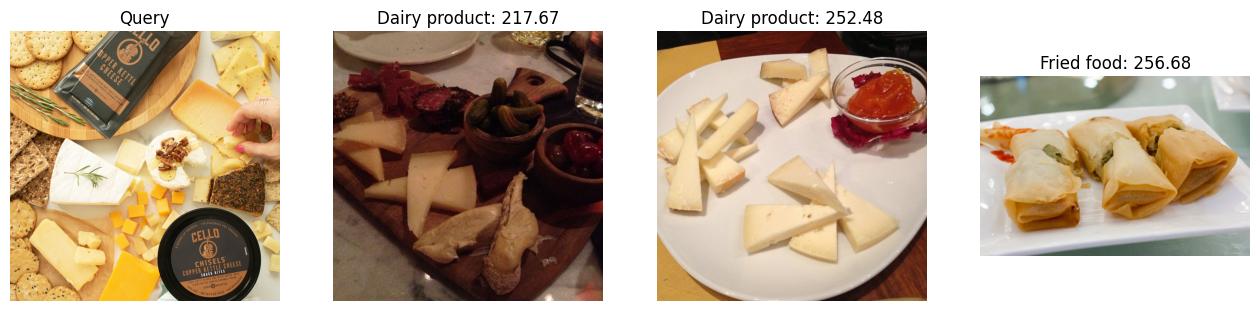

In [ ]:
query("https://i.imgur.com/lf5C0LI.png")

{'ids': [['77', '72', '73']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'test/Rice/7.jpg', 'name': 'Rice'},
   {'uri': 'test/Rice/2.jpg', 'name': 'Rice'},
   {'uri': 'test/Rice/3.jpg', 'name': 'Rice'}]],
 'distances': [[236.92507934570312, 249.4188232421875, 249.5189208984375]]}

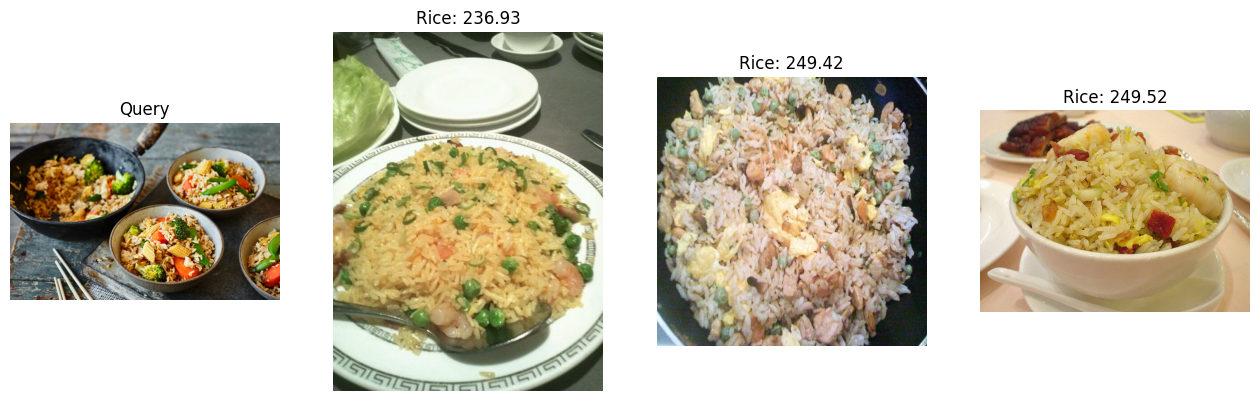

In [ ]:
query("https://i.imgur.com/WlLv0i9.png")